# Demographic development until 2070

Imports and set magics:

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import ipywidgets as widgets
from IPython.display import display
from matplotlib.ticker import MaxNLocator

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from IPython.display import display # For interactive figure

# Install DSTAPI to get data from statistikbanken
%pip install git+https://github.com/alemartinello/dstapi
from dstapi import DstApi

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import dataproject
data = dataproject

  Cloning https://github.com/alemartinello/dstapi to /private/var/folders/vj/yxjyqsh92md50khx532ch1qh0000gn/T/pip-req-build-2hlacpzb
  Running command git clone -q https://github.com/alemartinello/dstapi /private/var/folders/vj/yxjyqsh92md50khx532ch1qh0000gn/T/pip-req-build-2hlacpzb
  Resolved https://github.com/alemartinello/dstapi to commit d9eeb5a82cbc70b7d63b2ff44d92632fd77123a4
Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1) Data import and cleaning

1.1) Import and read data

In [14]:
#import and read
pop = DstApi('FRDK123') #Defining the data set
params = pop._define_base_params(language='en') #Language is set to english
pop.tablesummary(language='en') #Getting the table summary

Table FRDK123: Befolkningsfremskrivning 2023 for hele landet efter herkomst, køn, alder og tid
Last update: 2023-06-01T08:00:00


,variable name,# values,First value,First value label,Last value,Last value label,Time variable
0,HERKOMST,5,999,Personer med dansk oprindelse,35,Efterkommere fra ikke-vestlige lande,False
1,KØN,2,M,Mænd,K,Kvinder,False
2,ALDER,106,0,0 år,105-,105 år og derover,False
3,Tid,48,2023,2023,2070,2070,True


The above table summary shows the key information for the variables of our imported data set. 

1.2) Cleaning of data

In [15]:
#Defining the variables we want to use
params = {'table': 'FRDK123',
 'format': 'BULK',
 'lang': 'en',
 'variables': [{'code': 'HERKOMST', 'values': ['*']},
  {'code': 'KØN', 'values': ['M', 'K']},
  {'code': 'ALDER', 'values': ['>=0<=100']},
  {'code': 'Tid', 'values': ['*']}]}

#Getting the data
datapop_api = pop.get_data(params=params)

# Assuming df is your DataFrame and 'Alder' is the column with the ages
datapop_api['ALDER'] = datapop_api['ALDER'].str.extract('(\d+)').astype(int)

datapop_api.sample(n=10)

,HERKOMST,KØN,ALDER,TID,INDHOLD
8502,Descendants from non-western countries,Men,47,2049,2833
1012,Immigrants from western countries,Women,11,2029,573
12581,Immigrants from western countries,Women,54,2024,1700
27239,Immigrants from non-western countries,Women,45,2048,3092
16233,Persons of danish origin,Men,1,2063,32445
284,Immigrants from non-western countries,Women,82,2042,1436
13211,Immigrants from non-western countries,Men,36,2068,2592
25014,Persons of danish origin,Men,95,2058,3773
15053,Descendants from western countries,Women,11,2050,1789
33065,Descendants from western countries,Men,82,2070,119


## Exploration of data and analysis

/Users/laugekoch-klarskov/Desktop/uni/KA - 1. semester/projects-2024-william-ellen-og-lauge/dataproject/dataproject.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_df['INDHOLD'] = women_df['INDHOLD'] * -1
/Users/laugekoch-klarskov/Desktop/uni/KA - 1. semester/projects-2024-william-ellen-og-lauge/dataproject/dataproject.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(abs(tick)) for tick in ticks])


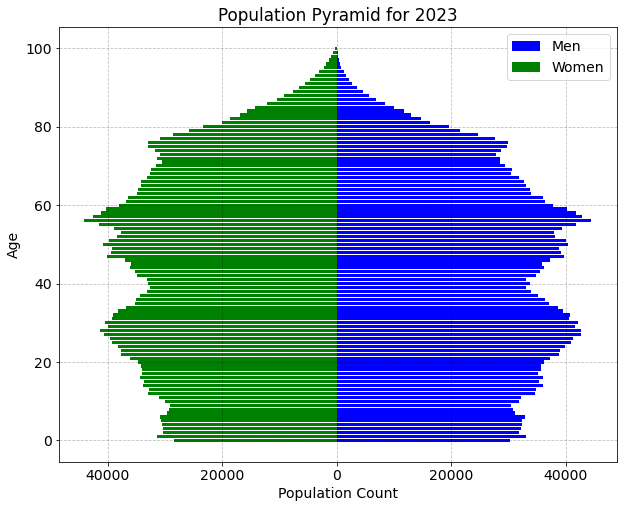

In [25]:
df = datapop_api[datapop_api["TID"] == 2023]
datapop_df = df.groupby(["KØN", "ALDER"])["INDHOLD"].sum().reset_index()
data.plot_population_pyramid(datapop_df)

**Interactive plot** :

In [26]:
def update_plot(year):
    # Filter the DataFrame for the selected year
    df_year = datapop_api[datapop_api["TID"] == year]
    
    # Group by gender and age, then sum the population count
    age_pyramid_data = df_year.groupby(["KØN", "ALDER"])["INDHOLD"].sum().unstack("KØN")
    
    # Make women's population negative for plotting
    age_pyramid_data['Women'] = -age_pyramid_data['Women']

    # Clear the previous figure and create a new one
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plot the data
    ax.barh(age_pyramid_data.index, age_pyramid_data['Men'], color='blue', label='Men')
    ax.barh(age_pyramid_data.index, age_pyramid_data['Women'], color='green', label='Women')

    # Set labels and title
    ax.set_xlabel('Population Count')
    ax.set_ylabel('Age')
    ax.set_title(f'Population Pyramid for {year}')
    ax.legend()


    ax.set_ylim(0, age_pyramid_data.index.max())

    # Change y-axis to show only labels for every 5 years.
    # Find the max age to set as the limit for the y-axis ticks.
    # max_age = age_pyramid_data.index.max() + (5 - age_pyramid_data.index.max() % 5)  # Round up to the nearest multiple of 5
    ax.set_yticks(np.arange(0, 101, 5))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure that only integer ticks are shown

    # Set the x-axis to show positive values for both sides
    ticks = ax.get_xticks()
    ax.set_xticklabels([int(abs(tick)) for tick in ticks])

    # Show grid
    ax.grid(True)

    # Display the plot
    plt.show()

# Create a slider for the year selection
years = datapop_api['TID'].unique()
year_slider = widgets.IntSlider(min=min(years), max=max(years), step=1, value=min(years), description='Year')

# Display the slider and attach the update function
widgets.interactive(update_plot, year=year_slider)


interactive(children=(IntSlider(value=2023, description='Year', max=2070, min=2023), Output()), _dom_classes=(…

Explain what you see when moving elements of the interactive plot around. 

# Overskrift

<Figure size 720x432 with 0 Axes>

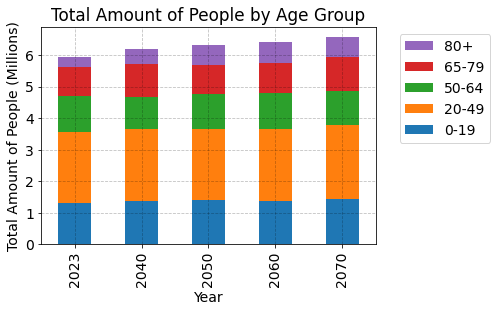

In [27]:
selected_years = [2023, 2040, 2050, 2060, 2070]
data.plot_age_groups(datapop_api, selected_years)

TEXT

<Figure size 720x432 with 0 Axes>

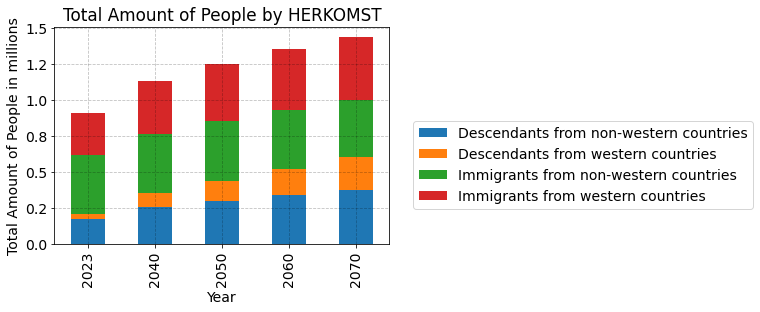

In [28]:
selected_years = [2023, 2040, 2050, 2060, 2070]
data.plot_herkomst_groups(datapop_api, selected_years)

# Conclusion